<a href="https://colab.research.google.com/github/xhxuciedu/CS206/blob/master/interior_point_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Interior point method for solving constrained optimization problems

1. **Problem Setup**: A quadratic optimization problem with:
   - Objective: minimize $$f(x)=(x_1 - 1)^2 + (x_2 - 2.5)^2$$
   - Constraints:
   $$x_1^2 + x_2^2 \le 2,\\ x_1 \ge 0,\\ x_2 \ge 0$$

2. **Log Barrier Method**: Converts the constrained problem into a sequence of unconstrained problems using the log barrier function:
   - $$\phi(x, t) = t·f(x) - \sum_i \log(-g_i(x))$$

3. **Central Path**: Shows how the solution evolves as the barrier parameter t increases

4. **Key Features**:
   - Newton's method for solving each barrier subproblem
   - Line search for ensuring feasibility
   - Visualization of the central path
   - Convergence monitoring through the barrier parameter

The visualization shows:
- Left plot: The central path from the initial point to the optimal solution
- Right plot: Evolution of the barrier parameter t (log scale)
- Additional visualization of log barrier functions for different t values

We will demonstrate how the interior point method approaches the optimal solution while maintaining strict feasibility throughout the optimization process.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

In [10]:
def interior_point_method_with_visualization():
    """
    Solve a 2D optimization problem using interior point method with log barrier

    Problem:
    minimize    f(x) = (x1 - 1)^2 + (x2 - 2.5)^2
    subject to  g1(x) = x1^2 + x2^2 - 2 <= 0
                g2(x) = -x1 <= 0
                g3(x) = -x2 <= 0
    """

    # Objective function
    def f(x):
        return (x[0] - 1)**2 + (x[1] - 2.5)**2

    # Gradient of objective function
    def grad_f(x):
        return np.array([2*(x[0] - 1), 2*(x[1] - 2.5)])

    # Hessian of objective function
    def hess_f(x):
        return np.array([[2, 0], [0, 2]])

    # Inequality constraints g_i(x) <= 0
    def g(x):
        return np.array([
            x[0]**2 + x[1]**2 - 2,  # Circle constraint
            -x[0],                    # x1 >= 0
            -x[1]                     # x2 >= 0
        ])

    # Jacobian of constraints
    def jac_g(x):
        return np.array([
            [2*x[0], 2*x[1]],
            [-1, 0],
            [0, -1]
        ])

    # Hessians of constraints
    def hess_g(x, i):
        if i == 0:
            return np.array([[2, 0], [0, 2]])
        else:
            return np.zeros((2, 2))

    # Log barrier function
    def log_barrier(x, t):
        g_vals = g(x)
        if np.any(g_vals >= 0):
            return np.inf
        return t * f(x) - np.sum(np.log(-g_vals))

    # Gradient of log barrier function
    def grad_log_barrier(x, t):
        g_vals = g(x)
        jac = jac_g(x)
        grad = t * grad_f(x)
        for i in range(len(g_vals)):
            grad += (1 / (-g_vals[i])) * jac[i]
        return grad

    # Hessian of log barrier function
    def hess_log_barrier(x, t):
        g_vals = g(x)
        jac = jac_g(x)
        hess = t * hess_f(x)

        for i in range(len(g_vals)):
            # First term: 1/(-g_i)^2 * ∇g_i * ∇g_i^T
            grad_gi = jac[i].reshape(-1, 1)
            hess += (1 / g_vals[i]**2) * (grad_gi @ grad_gi.T)

            # Second term: -1/g_i * ∇²g_i
            hess += -(1 / g_vals[i]) * hess_g(x, i)

        return hess

    # Newton's method for solving the barrier problem
    def newton_method(x0, t, tol=1e-6, max_iter=100):
        x = x0.copy()
        path = [x.copy()]

        for _ in range(max_iter):
            grad = grad_log_barrier(x, t)
            hess = hess_log_barrier(x, t)

            # Newton direction
            try:
                d = -np.linalg.solve(hess, grad)
            except:
                break

            # Line search
            alpha = 1.0
            while True:
                x_new = x + alpha * d
                if np.all(g(x_new) < 0) and log_barrier(x_new, t) < log_barrier(x, t):
                    break
                alpha *= 0.5
                if alpha < 1e-10:
                    break

            x = x + alpha * d
            path.append(x.copy())

            if np.linalg.norm(grad) < tol:
                break

        return x, path

    # Interior point method
    def interior_point(x0, mu=10, tol=1e-6):
        x = x0.copy()
        t = 1.0
        central_path = []
        t_values = []

        while True:
            # Solve barrier problem
            x, newton_path = newton_method(x, t, tol=tol)
            central_path.append(x.copy())
            t_values.append(t)

            # Check duality gap
            m = len(g(x))  # number of constraints
            if m / t < tol:
                break

            # Increase t
            t *= mu

        return x, central_path, t_values

    # Initial point (must be strictly feasible)
    x0 = np.array([0.5, 0.5])

    # Solve the problem
    x_opt, central_path, t_values = interior_point(x0, mu=10)

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Left plot: Contour plot with central path
    x1 = np.linspace(-0.5, 2, 400)
    x2 = np.linspace(-0.5, 3, 400)
    X1, X2 = np.meshgrid(x1, x2)
    Z = (X1 - 1)**2 + (X2 - 2.5)**2

    # Plot contours
    contour = ax1.contour(X1, X2, Z, levels=20, alpha=0.6)
    ax1.clabel(contour, inline=True, fontsize=8)

    # Plot constraints
    circle = Circle((0, 0), np.sqrt(2), fill=False, edgecolor='red', linewidth=2)
    ax1.add_patch(circle)
    ax1.axvline(x=0, color='red', linewidth=2)
    ax1.axhline(y=0, color='red', linewidth=2)

    # Shade feasible region
    theta = np.linspace(0, np.pi/2, 100)
    x_circle = np.sqrt(2) * np.cos(theta)
    y_circle = np.sqrt(2) * np.sin(theta)
    ax1.fill_between(x_circle, 0, y_circle, alpha=0.2, color='green')

    # Plot central path
    central_path = np.array(central_path)
    ax1.plot(central_path[:, 0], central_path[:, 1], 'b.-', linewidth=2,
             markersize=8, label='Central Path')

    # Mark initial and optimal points
    ax1.plot(x0[0], x0[1], 'go', markersize=10, label='Initial Point')
    ax1.plot(x_opt[0], x_opt[1], 'r*', markersize=15, label='Optimal Point')

    # True unconstrained optimum
    ax1.plot(1, 2.5, 'kx', markersize=12, label='Unconstrained Optimum')

    ax1.set_xlabel('x₁')
    ax1.set_ylabel('x₂')
    ax1.set_title('Interior Point Method: Central Path')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-0.5, 2)
    ax1.set_ylim(-0.5, 3)
    ax1.set_aspect('equal')

    # Right plot: Convergence of barrier parameter
    ax2.semilogy(range(len(t_values)), t_values, 'b.-', linewidth=2, markersize=8)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Barrier Parameter t')
    ax2.set_title('Evolution of Barrier Parameter')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print results
    print(f"Optimal solution: x* = [{x_opt[0]:.6f}, {x_opt[1]:.6f}]")
    print(f"Optimal value: f(x*) = {f(x_opt):.6f}")
    print(f"Constraint values at optimum: g(x*) = {g(x_opt)}")
    print(f"Number of iterations: {len(central_path)}")

    return x_opt, central_path, t_values

# Additional function to visualize log barrier function
def visualize_log_barrier():
    """Visualize the log barrier function for different values of t"""

    # Define the same problem
    def f(x):
        return (x[0] - 1)**2 + (x[1] - 2.5)**2

    def g(x):
        return np.array([
            x[0]**2 + x[1]**2 - 2,
            -x[0],
            -x[1]
        ])

    def log_barrier(x, t):
        g_vals = g(x)
        if np.any(g_vals >= 0):
            return np.inf
        # return t * f(x) - np.sum(np.log(-g_vals))
        return - np.sum(np.log(-g_vals))/t

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    t_values = [0.1, 1, 10, 100]

    for idx, t in enumerate(t_values):
        ax = axes[idx]

        # Create grid
        x1 = np.linspace(0.01, 1.4, 100)
        x2 = np.linspace(0.01, 1.4, 100)
        X1, X2 = np.meshgrid(x1, x2)

        # Compute log barrier values
        Z = np.zeros_like(X1)
        for i in range(X1.shape[0]):
            for j in range(X1.shape[1]):
                x = np.array([X1[i, j], X2[i, j]])
                Z[i, j] = log_barrier(x, t)
                if Z[i, j] == np.inf:
                    Z[i, j] = np.nan

        # Plot contours
        contour = ax.contour(X1, X2, Z, levels=30, alpha=0.8)
        ax.clabel(contour, inline=True, fontsize=6)

        # Plot feasible boundary
        theta = np.linspace(0, np.pi/2, 100)
        x_circle = np.sqrt(2) * np.cos(theta)
        y_circle = np.sqrt(2) * np.sin(theta)
        ax.plot(x_circle, y_circle, 'r-', linewidth=2)
        ax.axvline(x=0, color='red', linewidth=2)
        ax.axhline(y=0, color='red', linewidth=2)

        ax.set_xlabel('x₁')
        ax.set_ylabel('x₂')
        ax.set_title(f'Log Barrier Function (t = {t})')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1.4)
        ax.set_ylim(0, 1.4)
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

Interior Point Method with Log Barrier


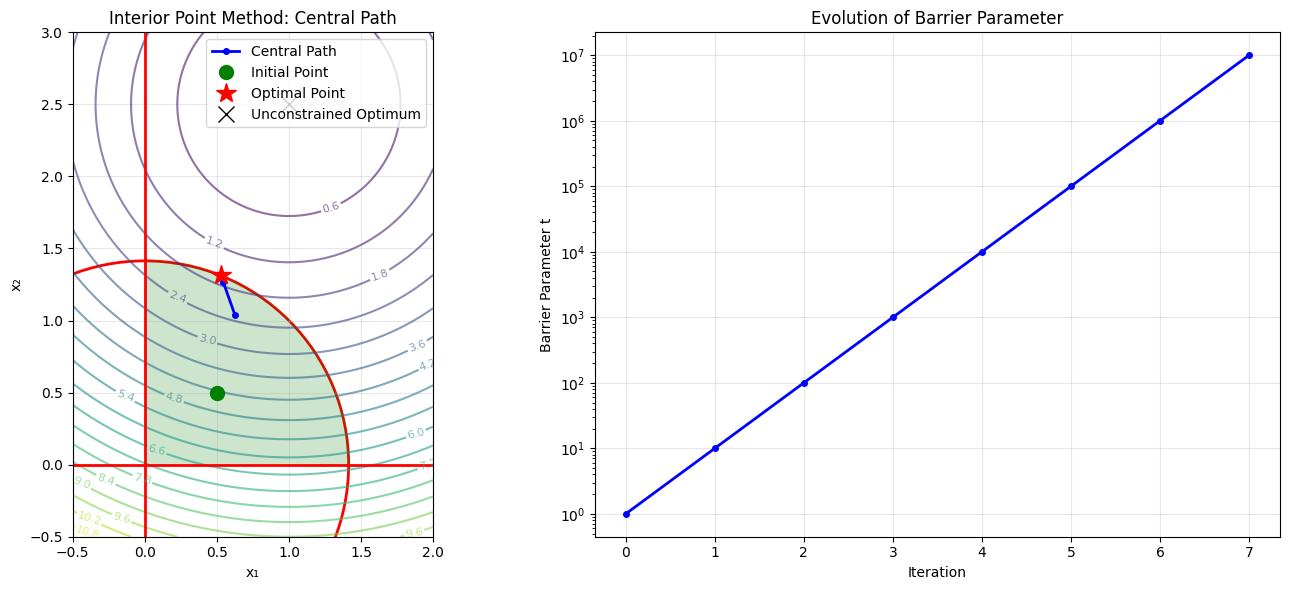

Optimal solution: x* = [0.525226, 1.313064]
Optimal value: f(x*) = 1.634227
Constraint values at optimum: g(x*) = [-1.10626397e-07 -5.25225753e-01 -1.31306428e+00]
Number of iterations: 8


In [8]:
print("Interior Point Method with Log Barrier")
print("="*50)

# Solve the problem and visualize
x_opt, central_path, t_values = interior_point_method_with_visualization()


Visualizing log barrier function for different values of t...


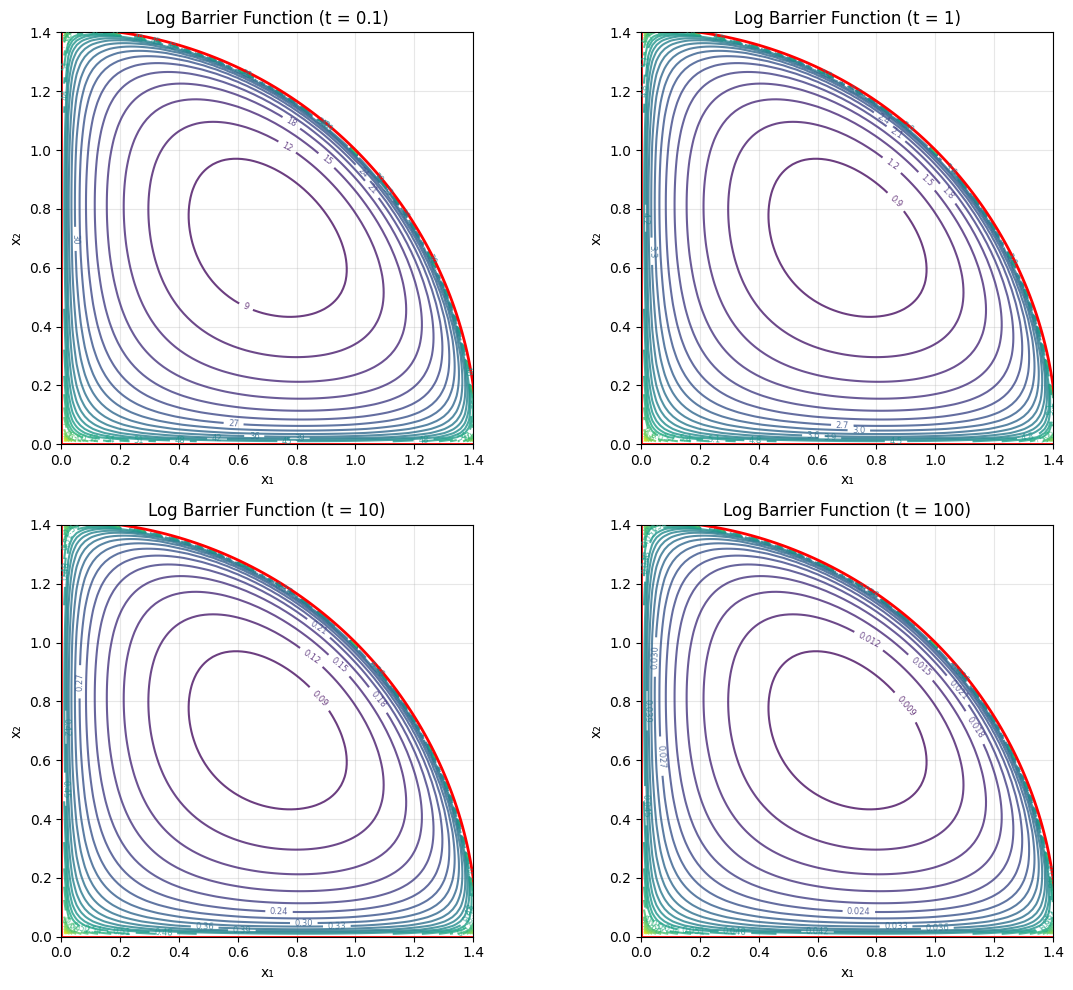

In [11]:

# Visualize log barrier function
print("\nVisualizing log barrier function for different values of t...")
visualize_log_barrier()
